In [291]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"]=10,3
text_size = 20
plt.rc('xtick', labelsize=text_size) 
plt.rc('ytick', labelsize=text_size) 
line_width = 2.5
plt.style.use('ggplot')
sns.set_palette("twilight")

In [293]:
def get_number_string(string):
    import re
    s = [float(s) for s in re.findall(r'-?\d+\.?\d*', string)]
    return s[0]

def read_xvg(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            try:
                x1 = float(line.split()[0])
                y1 = float(line.split()[1])
                x.append(x1)
                y.append(y1)
            except ValueError:
                pass
    return x, y

def get_df(to_read):
    # define locations of files
    k_310_2 =  '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations/310K/2'
    k_310_1 = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations/310K/1'
    k_400 = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations/400K'
    base = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations'
    # read data
    os.chdir(k_310_1)
    x_310_1, y_310_1 = read_xvg(to_read)

    os.chdir(k_310_2)
    x_310_2, y_310_2 = read_xvg(to_read)

    os.chdir(k_400)
    x_400, y_400 = read_xvg(to_read)
    # create data frame and melt
    df_dict = {"x": x_310_1,
          "310K - 1" : y_310_1,
          "310K - 2" : y_310_2,
          "400K" : y_400}

    df = pd.DataFrame(df_dict)
    df = pd.melt(df, id_vars=['x'], value_vars=['310K - 1', '310K - 2', '400K'])
    df.columns = ['Time', 'Simulation', 'value']
    os.chdir(base)
    return df

def plot_joint(data, text_size = 15, xlabel = "Time", ylabel = "RMS"):
    plt.style.use('ggplot')
    sns.set_palette("twilight")
    plt.rc('xtick', labelsize=text_size) 
    plt.rc('ytick', labelsize=text_size) 

    f, axs = plt.subplots(1,2,
                      figsize=(10,3),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[3,0.5]))

    sns.lineplot(data = data,
                x = "Time",
                y = "value",
                hue = "Simulation",
                ax = axs[0])


    sns.kdeplot(data = data,
                y = "value",
                hue = "Simulation",
                legend = False,
                ax = axs[1])
    axs[0].set_xlabel(xlabel, size = text_size) 
    axs[0].set_ylabel(ylabel, size = text_size)
    axs[1].set_xlabel("", size = text_size) 
    axs[1].axes.get_xaxis().set_visible(False)
    axs[0].legend(title = "Simulation", fontsize=text_size, title_fontsize=text_size)

    f.tight_layout()
    
def get_mean(df):
    return df.groupby("Simulation")["value"].mean()

def plot_fes(number, text_size = 15, xlabel = "CV", ylabel = "Bias potential"):
    """ 
    number - metadynamics simulation number 
    """
    plt.rc('xtick', labelsize=text_size) 
    plt.rc('ytick', labelsize=text_size) 
    base = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations'
    plot = str(number)
    os.chdir(base + "/Metadynamics/" + plot + "/fes_data")
    file_list = os.listdir()
    df_full = pd.DataFrame()
    for file in file_list:
        if "fes" in file:
            number = get_number_string(file)
            x, y = read_xvg(file)
            df_dict = {"Step" : number,
                      "x": x,
                      "y": y}
            df = pd.DataFrame(df_dict)
            df_full = df_full.append(df)
    sns.lineplot(data = df_full,
            x = "x",
            y = "y",
            hue = "Step")
    plt.ylabel(ylabel, fontsize=text_size)
    plt.xlabel(xlabel, fontsize=text_size)
    plt.tight_layout()
    os.chdir(base)

def plot_cv(number, text_size = 15, ylabel = "CV", xlabel = "Time"):
    """ 
    number - metadynamics simulation number 
    """
    plt.rc('xtick', labelsize=text_size) 
    plt.rc('ytick', labelsize=text_size) 
    base = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations'
    plot = str(number)
    x, y = read_xvg(base + "/Metadynamics/" + plot + '/COLVAR')
    plt.ylabel(ylabel, fontsize=text_size)
    plt.xlabel(xlabel, fontsize=text_size)
    plt.plot(x, y)
    plt.tight_layout()

# RMS

## RMS - whole protein

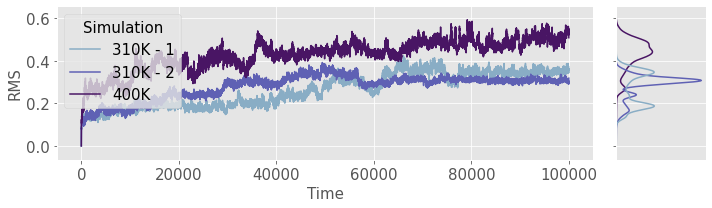

In [103]:
to_read = "rms.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15)
plt.savefig("Figures/RMS.png")

In [104]:
get_mean(df)

Simulation
310K - 1    0.263979
310K - 2    0.279671
400K        0.428676
Name: value, dtype: float64

# Distance

## Between A and rest

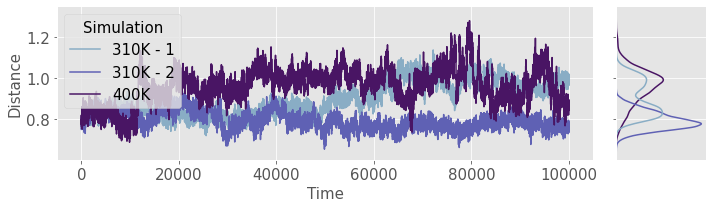

In [294]:
to_read = "distance_a_rest.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Distance")
plt.savefig("Figures/dist_a_rest.png")

In [301]:
df[df.Simulation == "400K"].head()

,Time,Simulation,value
40002,0.0,400K,0.796
40003,5.0,400K,0.774
40004,10.0,400K,0.780
40005,15.0,400K,0.806
40006,20.0,400K,0.819


In [70]:
get_mean(df)

Simulation
310K - 1    0.898730
310K - 2    0.791872
400K        0.959203
Name: value, dtype: float64

## Between A terminus

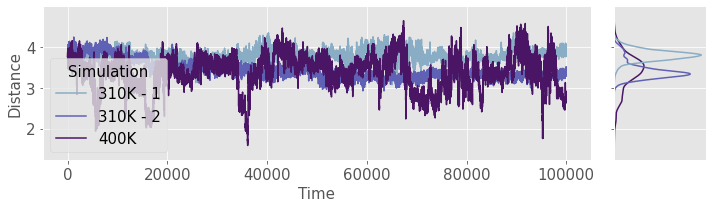

In [71]:
to_read = "distance_end.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Distance")
plt.savefig("Figures/dist_a_terminus.png")

In [72]:
get_mean(df)

Simulation
310K - 1    3.799934
310K - 2    3.430173
400K        3.383105
Name: value, dtype: float64

# Hydrogen bonds

## In the whole protein system

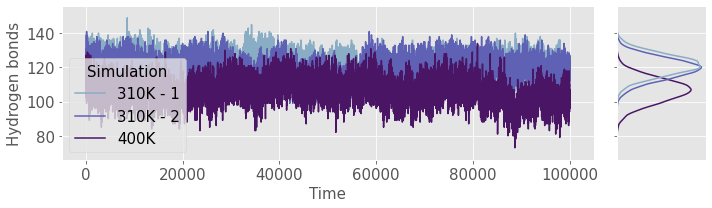

In [73]:
to_read = "hbonds_protein.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Hydrogen bonds")
plt.savefig("Figures/hb_sys.png")

In [74]:
get_mean(df)

Simulation
310K - 1    121.386381
310K - 2    119.101495
400K        106.400630
Name: value, dtype: float64

## between chain A and the rest

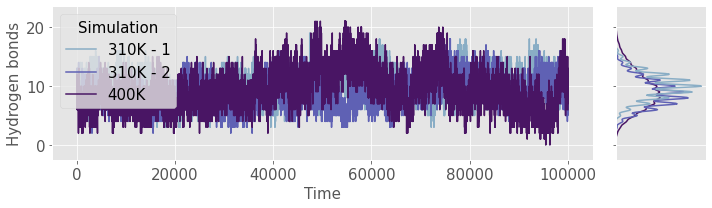

In [302]:
to_read = "hb_a_rest.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Hydrogen bonds")
plt.savefig("Figures/hb_a_rest.png")

In [76]:
get_mean(df)

Simulation
310K - 1    10.043498
310K - 2     8.765562
400K         9.342183
Name: value, dtype: float64

# Properties

## Potential energy

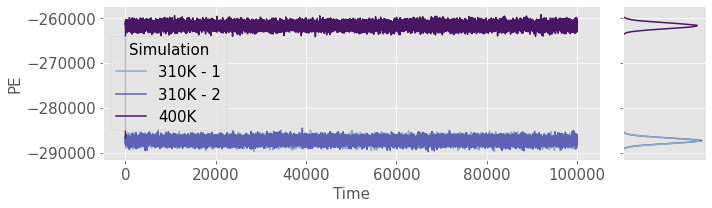

In [77]:
to_read = "potential.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "PE")
plt.savefig("Figures/PE.png")

In [78]:
get_mean(df)

Simulation
310K - 1   -287393.262343
310K - 2   -287359.995510
400K       -261784.285952
Name: value, dtype: float64

## Temperature

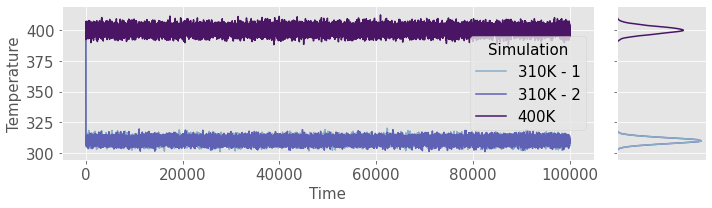

In [79]:
to_read = "temperature.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Temperature")
plt.savefig("Figures/temperature.png")

In [80]:
get_mean(df)

Simulation
310K - 1    310.011419
310K - 2    310.017205
400K        400.005701
Name: value, dtype: float64

## Pressure

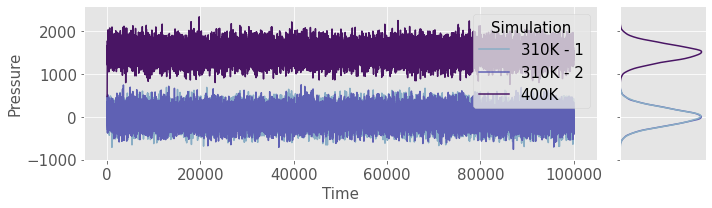

In [81]:
to_read = "pressure.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Pressure")
plt.savefig("Figures/pressure.png")

In [82]:
get_mean(df)

Simulation
310K - 1       0.454447
310K - 2       2.550137
400K        1500.272632
Name: value, dtype: float64

## Volume

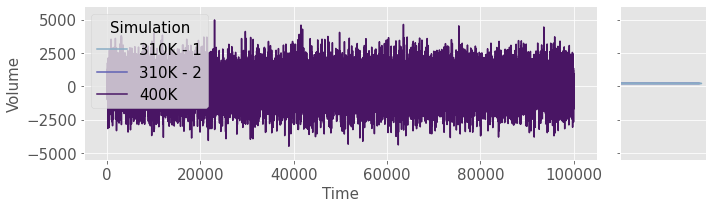

In [84]:
to_read = "volume.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Volume")
plt.savefig("Figures/volume.png")

In [93]:
get_mean(df)

Simulation
310K - 1    215.088178
310K - 2    215.144425
400K         17.927853
Name: value, dtype: float64

# Metadynamics

## Simulation 1 - terminus

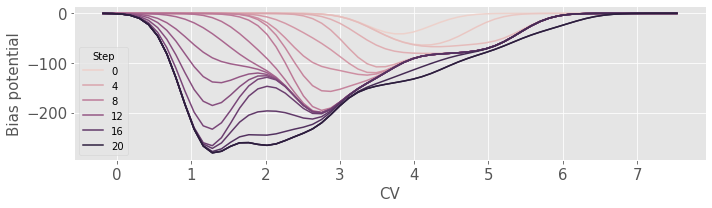

In [287]:
plot_fes(1, text_size = 15)
plt.savefig("Figures/mtd-1.png")

## Simulation 2 - chain A and rest of the complex

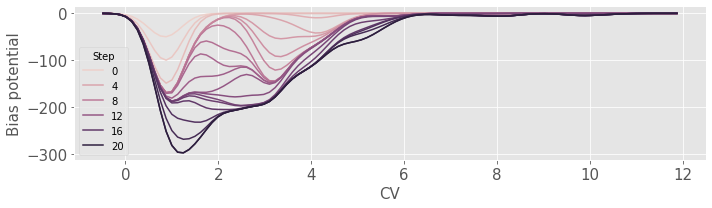

In [288]:
plot_fes(2, text_size = 15)
plt.savefig("Figures/mtd-2.png")

## Simulation 3 - terminus

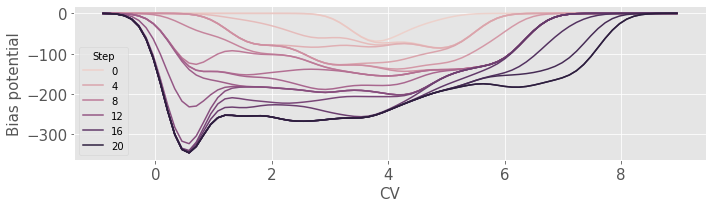

In [289]:
plot_fes(3, text_size = 15)
plt.savefig("Figures/mtd-3.png")